In [13]:
import sys
sys.path.append('../../../src/')
import re
import pandas as pd
import os
import torch
import esm
from proteusAI.ML.plm import *
from proteusAI.io_tools import *
from scipy.stats import pearsonr
from proteusAI.data.pdb import show_pdb
import seaborn as sns

# Initialize a dictionary to map amino acids to their index in the alphabet
alphabet = alphabet.to_dict()

In [55]:
def parse_substitution(substitution):
    match = re.match(r"([A-Za-z])(\d+)([A-Za-z])", substitution)
    if match:
        return match.groups()
    return None, None, None


def calculate_entropy_correlation(name, seq):
    entropy = torch.load(f"../results/{name}/{name}_per_position_entropy.pt", map_location="cpu")

    # Create a binary vector representing the presence of a mutation at each position
    mutation_occurrence = [0] * len(seq)

    for index, row in data.iterrows():
        if row["gene"] == name:
            wildtype_aa, position, substitute_aa = parse_substitution(row["substitution"])
            if wildtype_aa and position and substitute_aa:
                position = int(position)
                mutation_occurrence[position - 1] = 1

    # Calculate correlation between entropy and whether a mutation occurs at each position
    correlation_entropy_occurrence, _ = pearsonr(entropy[0].numpy(), mutation_occurrence)

    return correlation_entropy_occurrence


def calculate_mmp_correlation(name, seq, vs="average"):
    mmp = torch.load(f"../results/{name}/{name}_masked_marginal_probability.pt", map_location="cpu")

    # Create lists to store the mmp values of the substituted amino acids and the sum of mmp values of all other amino acids
    substituted_mmp_values = []
    other_mmp_values_sum = []

    for index, row in data.iterrows():
        if row["gene"] == name:
            wildtype_aa, position, substitute_aa = parse_substitution(row["substitution"])
            if wildtype_aa and position and substitute_aa:
                position = int(position) - 1  # Convert to 0-indexed
                substitute_aa_index = alphabet[substitute_aa]  # Get the index of the substituted amino acid
                
                # Get the mmp value of the substituted amino acid
                mmp_value = mmp[0, position, substitute_aa_index].item()
                substituted_mmp_values.append(mmp_value)

                # Calculate the sum of mmp values for all other amino acids at the mutated position
                other_mmp_values = [mmp[0, position, i].item() for i in range(mmp.shape[2]) if i != substitute_aa_index]
                if vs == "average":
                    other_mmp_values_sum.append(sum(other_mmp_values)/mmp.shape[2]-1)
                if vs == "sum":
                    other_mmp_values_sum.append(sum(other_mmp_values)/mmp.shape[2])

    # Calculate correlation between the mmp values of the substituted amino acids and the sum of mmp values of all other amino acids
    correlation_substituted_mmp_other_mmp, _ = pearsonr(substituted_mmp_values, other_mmp_values_sum)

    return correlation_substituted_mmp_other_mmp, substituted_mmp_values, other_mmp_values_sum


def plot_entropy_with_highlighted_mutations(name: str, sequence: str):
    # Load the entropy tensor
    entropy = torch.load(f"../results/{name}/{name}_per_position_entropy.pt", map_location="cpu")

    # Find the mutated positions for the given gene
    mutated_positions = []
    for index, row in data.iterrows():
        if row["gene"] == name:
            position = int(row["substitution"][1:-1]) - 1  # 0-indexed
            mutated_positions.append(position)

    title = f"Per position entropy of {name}"
    
    # Plot the per position entropy with highlighted mutated positions
    plot_per_position_entropy(entropy, sequence, highlight_positions=mutated_positions, show=True, title=title)
    
    
def plot_heatmap_with_highlighted_mutations(name: str, sequence: str, alphabet, heatmap_type: str = "mmp"):
    # Load the heatmap tensor based on the heatmap type
    if heatmap_type == "p":
        heatmap_tensor = torch.load(f"../results/{name}/{name}_prob_dist.pt", map_location="cpu")
        color_sheme = "b"
        title = f"Per probability distribution probability of {name}"
    elif heatmap_type == "mmp":
        heatmap_tensor = torch.load(f"../results/{name}/{name}_masked_marginal_probability.pt", map_location="cpu")
        color_sheme = "rwb"
        title = f"Per position masked marginal probability of {name}"
    else:
        raise ValueError("Invalid heatmap_type. Accepted values are 'pd' or 'mmp'.")

    # Find the mutated positions for the given gene
    mutations = {}
    for index, row in data.iterrows():
        if row["gene"] == name:
            position = int(row["substitution"][1:-1]) - 1  # 0-indexed
            mutated_residue = row["substitution"][-1]
            mutations[position] = mutated_residue

    # Plot the heatmap with highlighted mutated positions
    plot_heatmap(heatmap_tensor, alphabet, highlight_positions=mutations, show=True, color_sheme=color_sheme, title=title)
    
def plot_entropy_density(name: str, sequence: str, data: pd.DataFrame):
    # Load the entropy tensor
    entropy = torch.load(f"../results/{name}/{name}_per_position_entropy.pt", map_location="cpu")

    # Find the mutated positions for the given gene
    mutated_positions = []
    for index, row in data.iterrows():
        if row["gene"] == name:
            position = int(row["substitution"][1:-1]) - 1  # 0-indexed
            mutated_positions.append(position)

    mutated_positions_tensor = torch.tensor(mutated_positions, dtype=torch.long)
    all_positions = list(range(entropy.shape[1]))
    mutated_entropies = entropy[0, mutated_positions_tensor].numpy()
    all_entropies = entropy[0].numpy()
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(all_entropies, label="All positions")
    sns.kdeplot(mutated_entropies, label="Mutated positions")
    plt.xlabel("Entropy")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Probability density of all positions and mutated positions for {name}")
    plt.show()

mreB
Pearson correlation for the occurence of mutations based on entropy: 0.0775279792612142
Pearson for of the substituted amino acid being chosen at the mutated position: 0.9524409853202791


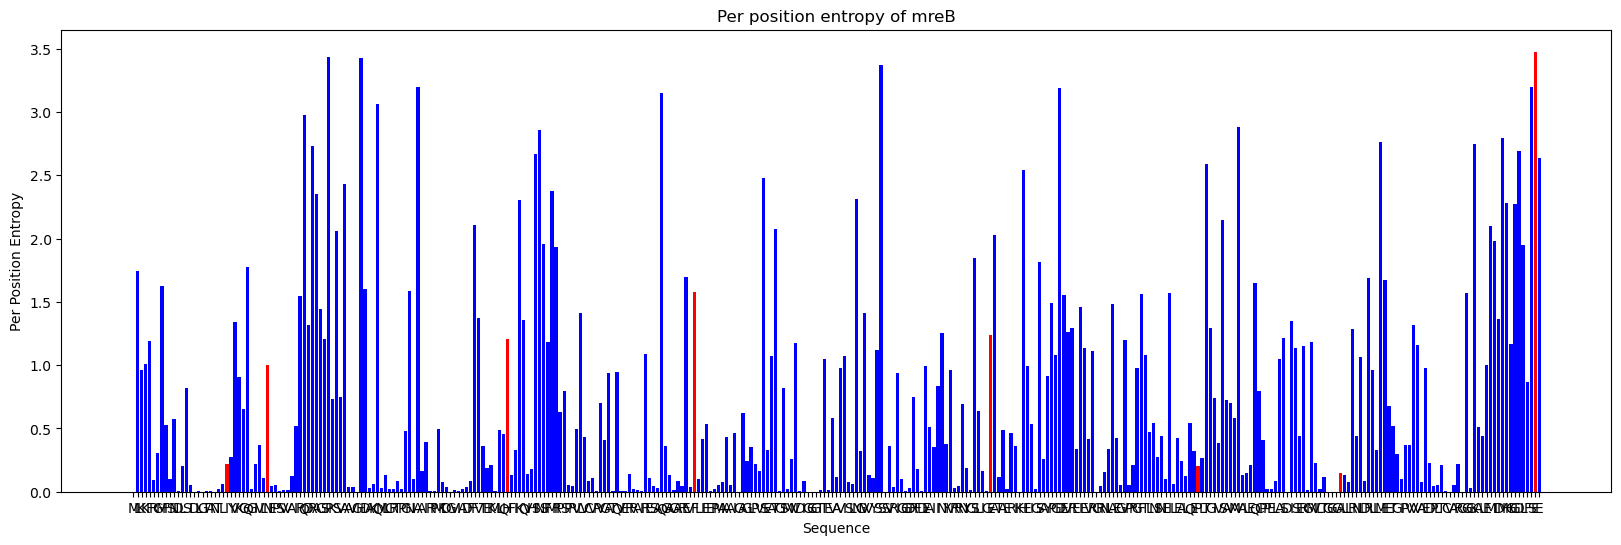

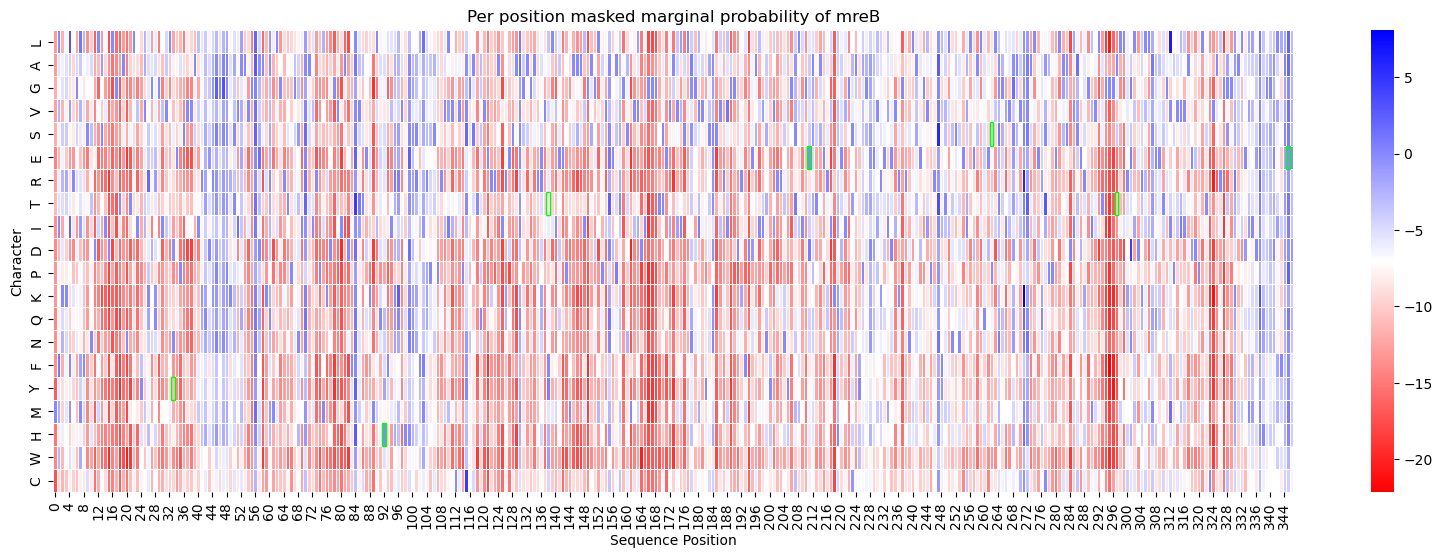

rho
Pearson correlation for the occurence of mutations based on entropy: -0.06341805201748864
Pearson for of the substituted amino acid being chosen at the mutated position: 0.8337756802536559


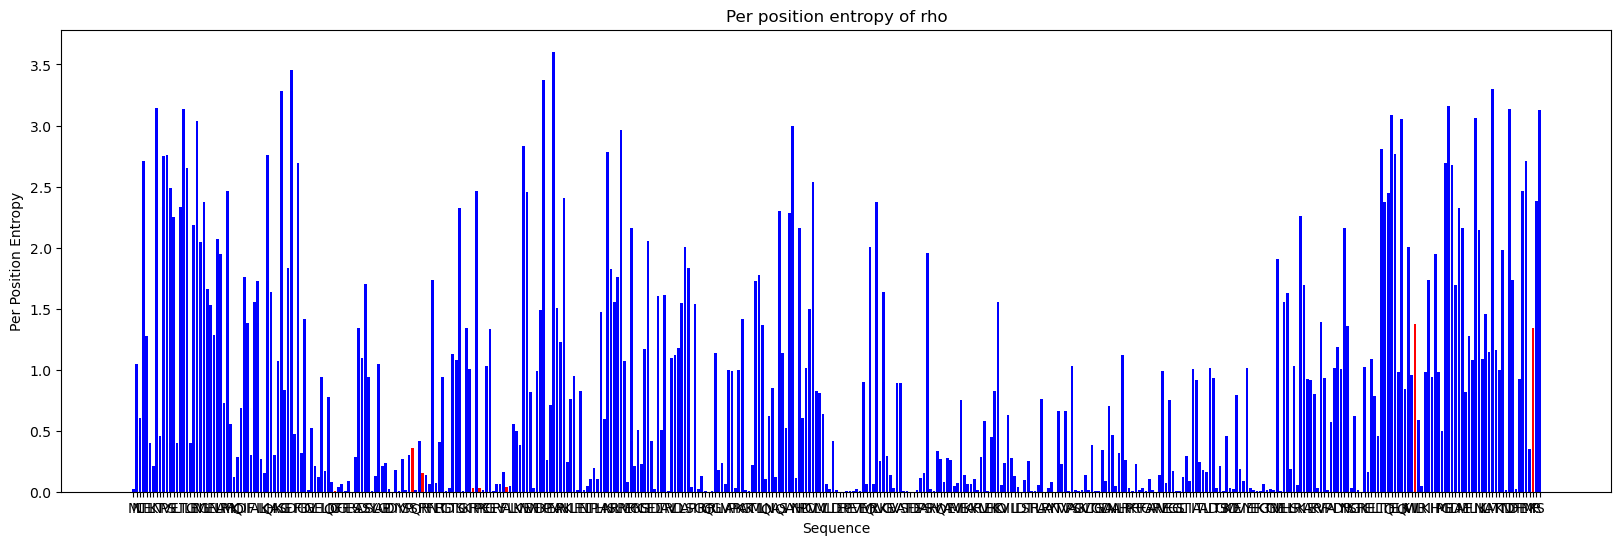

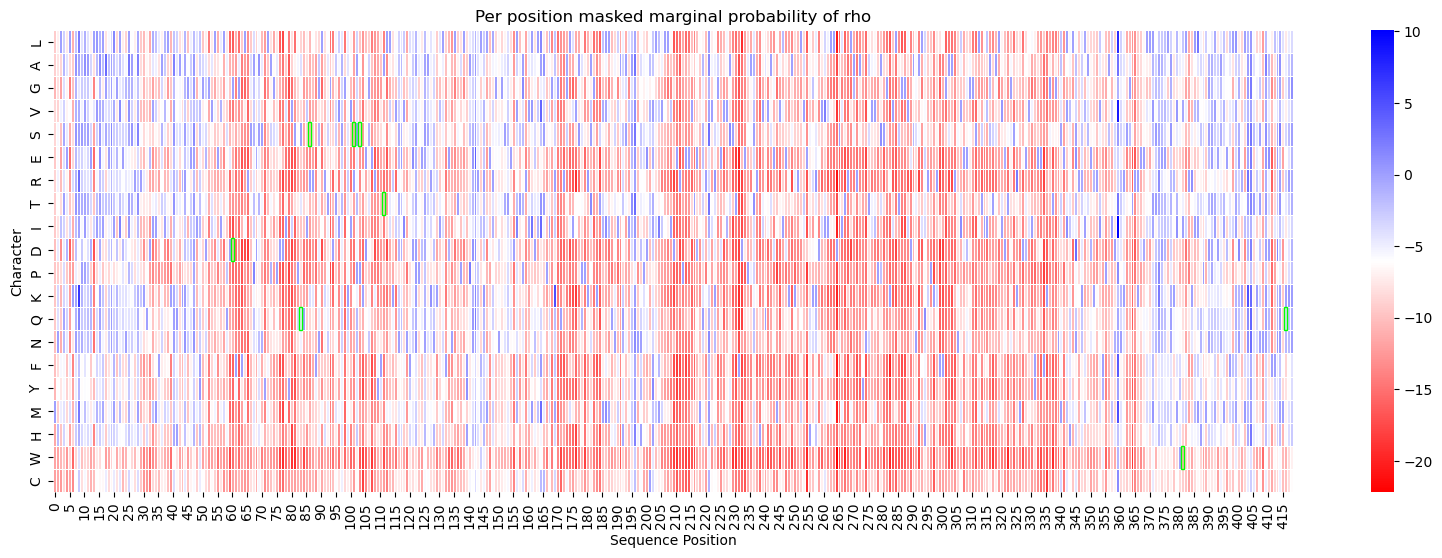

spoT
Pearson correlation for the occurence of mutations based on entropy: -0.09895559614373194
Pearson for of the substituted amino acid being chosen at the mutated position: 0.8100897920561253


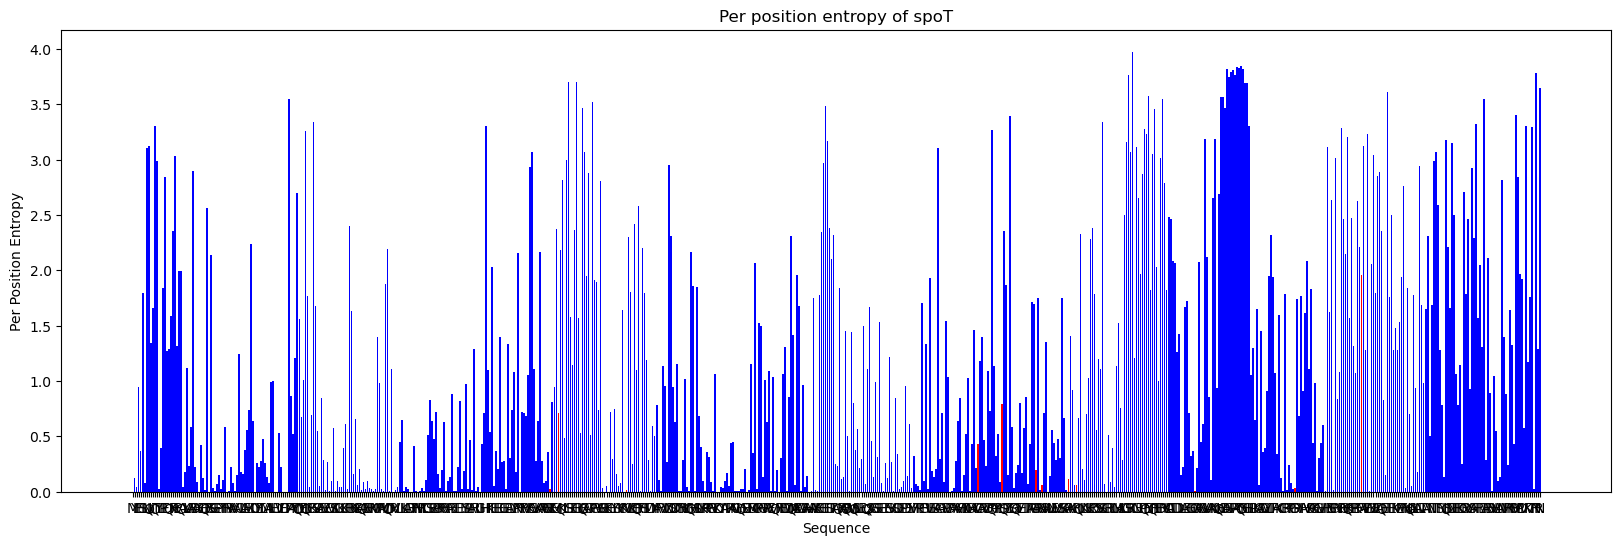

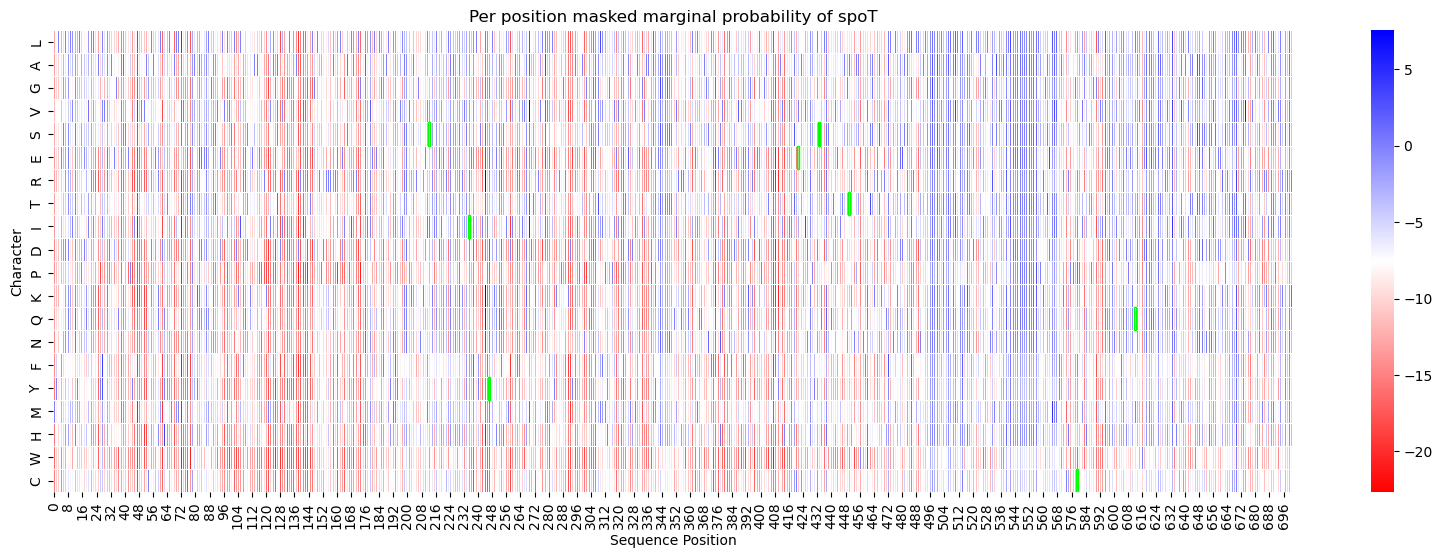

rpoA
Pearson correlation for the occurence of mutations based on entropy: -0.22267009882867272
Pearson for of the substituted amino acid being chosen at the mutated position: 0.7623319106989914


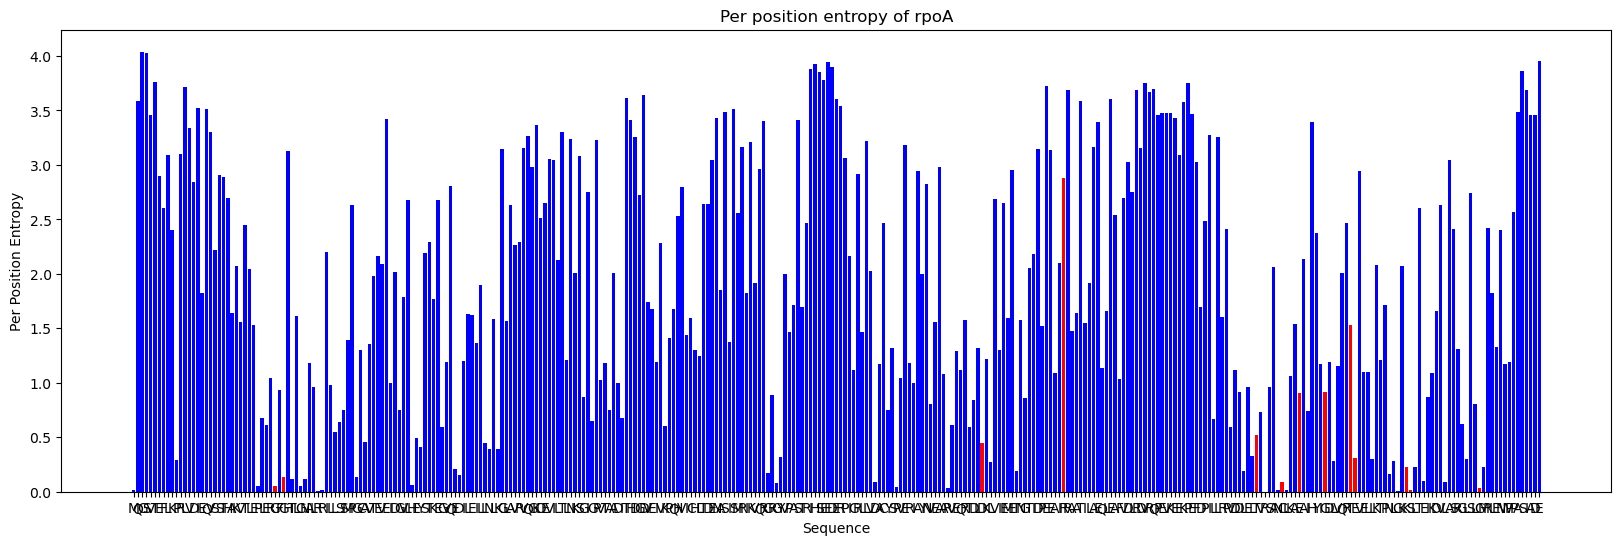

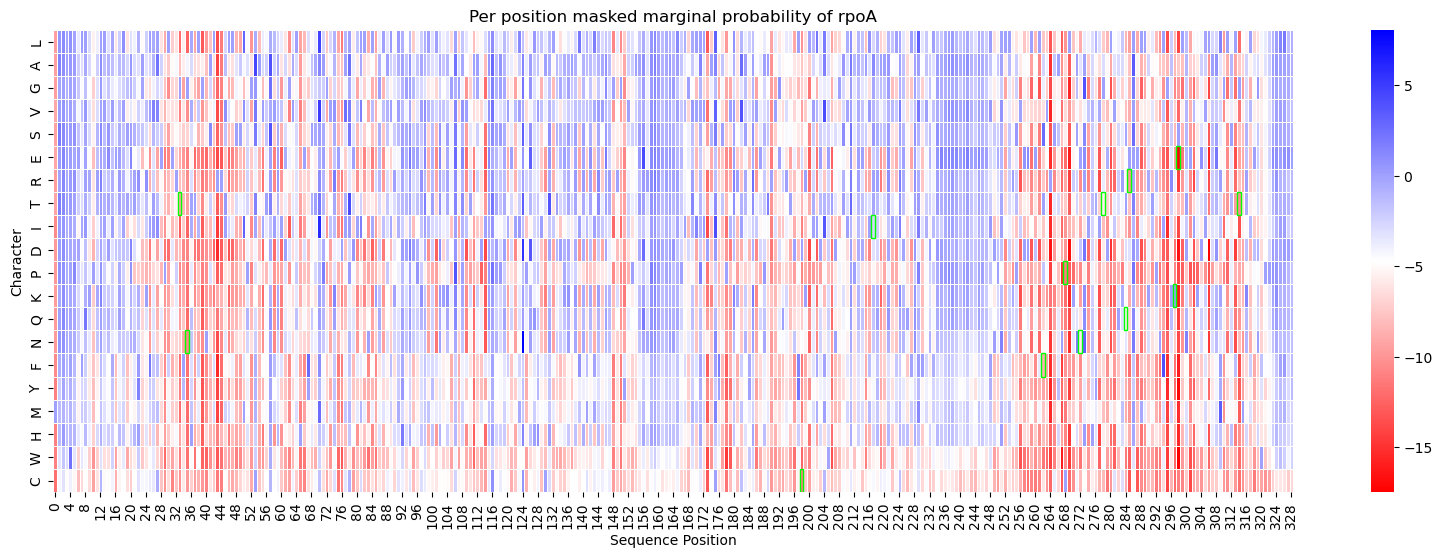

metJ
Pearson correlation for the occurence of mutations based on entropy: -0.10591561731601794
Pearson for of the substituted amino acid being chosen at the mutated position: 0.5287034862130648


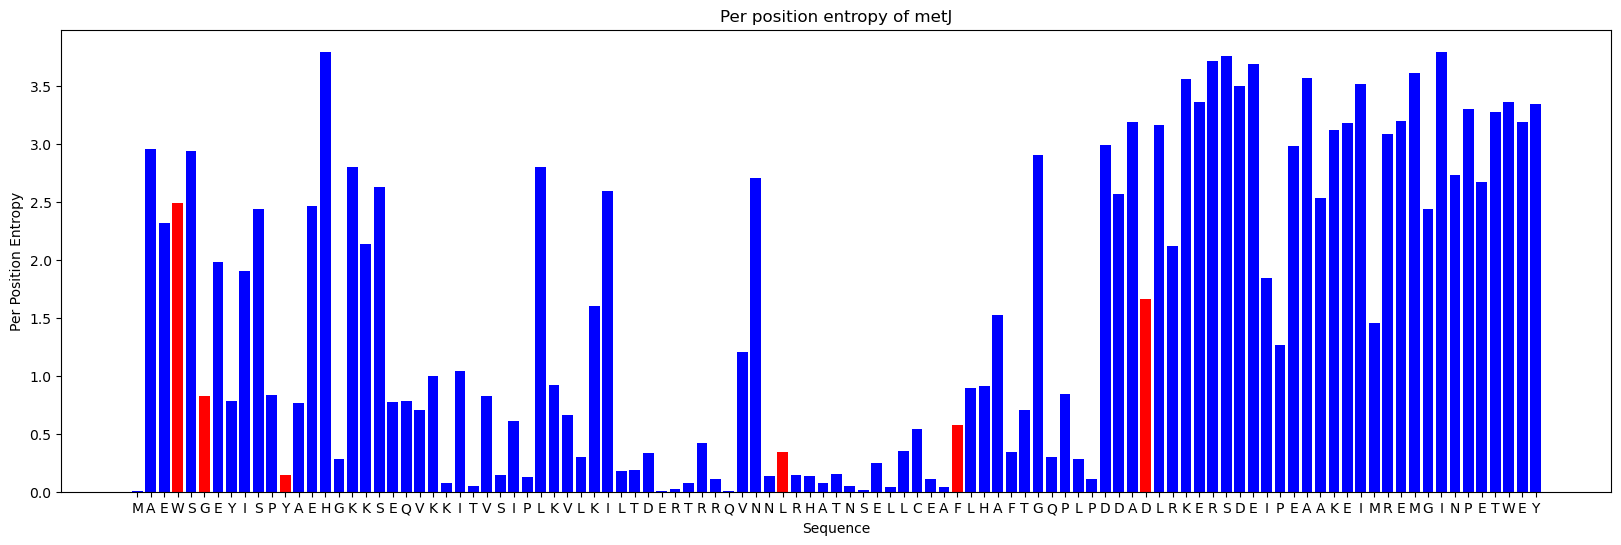

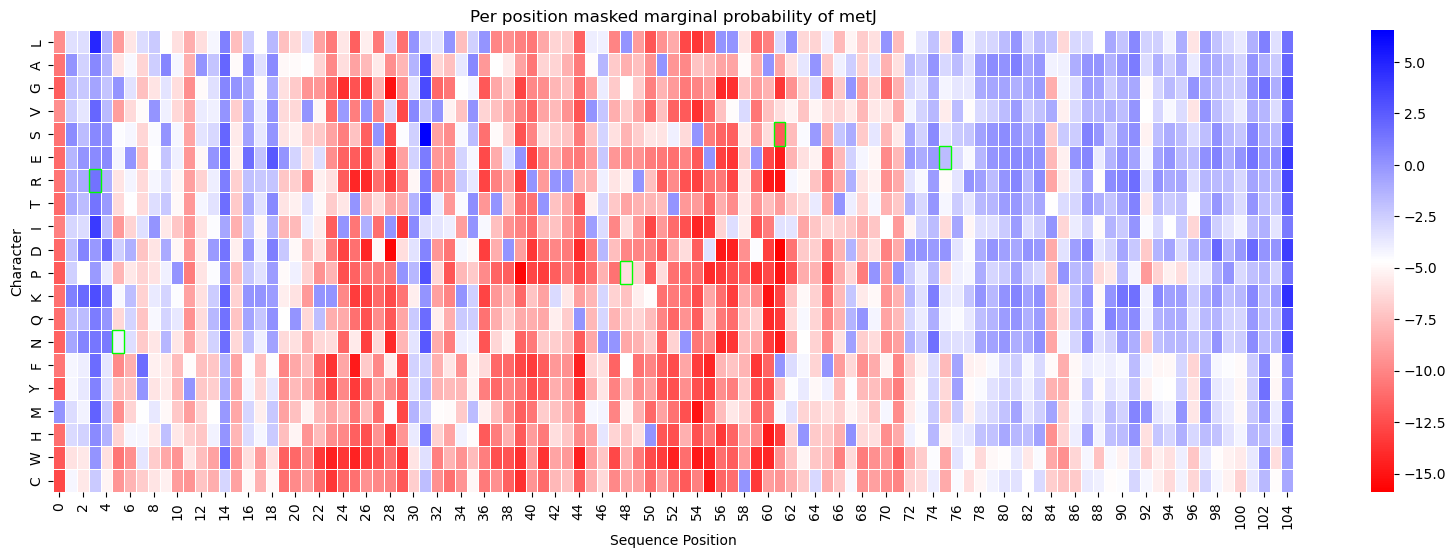

In [82]:
# Load the data
data_path = "../ind_chem_tol_ai-master/"
data = pd.read_csv(os.path.join(data_path, "aledb_snp_df.csv"))
fasta_path = os.path.join(data_path, 'data/fastas')
gene_name_pattern = re.compile(r"GN=([^ ]*)")

names, seqs = load_all_fastas(fasta_path)
names = [gene_name_pattern.search(n).group(1) for n in names if gene_name_pattern.search(n)]

for name, seq in zip(names, seqs):
    print(name)
    correlation_entropy_occurrence = calculate_entropy_correlation(name, seq)
    correlation_mmp_occurrence, _, _ = calculate_mmp_correlation(name, seq)
    print(f"Pearson correlation for the occurence of mutations based on entropy: {correlation_entropy_occurrence}")
    print(f"Pearson for of the substituted amino acid being chosen at the mutated position: {correlation_mmp_occurrence}")
    plot_entropy_with_highlighted_mutations(name, seq)
    plot_heatmap_with_highlighted_mutations(name, seq, alphabet, heatmap_type="mmp")

# Statistical analysis
---
## Mann-Whitney U test
The Mann-Whitney U test, also known as the Wilcoxon rank-sum test, is a nonparametric statistical test used to compare two independent samples. It determines whether there is a significant difference between the distributions of the samples or, more specifically, whether one sample tends to have larger values than the other. Nonparametric tests like the Mann-Whitney U test do not assume that the data follows a specific distribution, such as a normal distribution, making them more robust to non-normally distributed data.

The null hypothesis (H0) of the Mann-Whitney U test is that the distributions of the two samples are equal, and there is no significant difference between them. The alternative hypothesis (H1) is that the distributions of the two samples are not equal, and one sample tends to have larger values than the other.

In the context of our problem, the two samples being compared are:

1. The entropies of mutated positions.
2. The entropies of randomly drawn positions.

The Mann-Whitney U test is performed on these two samples, and the test statistic and p-value are calculated. The p-value is the probability of observing the test statistic or a more extreme value under the null hypothesis. If the p-value is small (typically below 0.05), we reject the null hypothesis and conclude that the mutated positions are significantly different from randomly drawn positions. If the p-value is not small, we cannot reject the null hypothesis, and there is not enough evidence to claim that the mutated positions are significantly different from randomly drawn positions.

It is important to note that a low p-value does not prove causality or the exact nature of the relationship between the mutated positions and randomly drawn positions. It only suggests that the two samples are significantly different. Additionally, the choice of the significance level (e.g., 0.05) is somewhat arbitrary, and the results should be interpreted with caution, especially when dealing with multiple comparisons or a small sample size.

## Permutation test
A permutation test, also known as a randomization test or re-randomization test, is a non-parametric statistical method used to test the null hypothesis by comparing an observed test statistic to a null distribution generated through permutations of the data. Permutation tests make fewer assumptions about the underlying distribution of the data, making them more robust and applicable to a wide range of situations.

The basic idea behind a permutation test is to generate a distribution of the test statistic under the null hypothesis by repeatedly shuffling the data and recalculating the test statistic. By comparing the observed test statistic to the distribution generated from permutations, we can estimate the probability of observing the test statistic or a more extreme value under the null hypothesis.

Here is a step-by-step explanation of the permutation test:

1. Compute the observed test statistic for the original data. In our case, it is the correlation between the masked marginal probability (MMP) values of the chosen mutations and the sum of MMP values of all other amino acids at the mutated positions.

2. Generate a null distribution of the test statistic by permuting the data. This is done by shuffling the MMP values of the chosen mutations and recalculating the test statistic (correlation) for each permutation. Repeat this process a large number of times (e.g., 1000 or more) to obtain a good approximation of the null distribution.

3. Calculate the p-value as the proportion of permuted test statistics at least as extreme as the observed test statistic. The p-value is the probability of observing a test statistic as extreme or more extreme than the observed one under the null hypothesis.

4. Compare the p-value to a predetermined significance level (e.g., 0.05). If the p-value is less than the significance level, reject the null hypothesis and conclude that the chosen mutations are significantly influenced by their masked marginal probability. If the p-value is greater than or equal to the significance level, do not reject the null hypothesis, and there is not enough evidence to claim that the chosen mutations are significantly influenced by their masked marginal probability.

Permutation tests have some notable advantages. They are distribution-free, meaning they make no assumptions about the underlying distribution of the data, which makes them more robust than parametric tests that rely on assumptions about the data distribution. Additionally, they can be applied to a wide range of test statistics and data types.

However, permutation tests can be computationally expensive, especially when dealing with large datasets, as they require many permutations to approximate the null distribution accurately.

In [124]:
import numpy as np
from scipy.stats import mannwhitneyu, pearsonr

def perform_statistical_test(name: str, sequence: str, data: pd.DataFrame, num_random_samples: int=None, replace: bool=True):
    # Load the entropy tensor
    entropy = torch.load(f"../results/{name}/{name}_per_position_entropy.pt", map_location="cpu")

    # Find the mutated positions for the given gene
    mutated_positions = []
    for index, row in data.iterrows():
        if row["gene"] == name:
            position = int(row["substitution"][1:-1]) - 1  # 0-indexed
            mutated_positions.append(position)

    mutated_positions_tensor = torch.tensor(mutated_positions, dtype=torch.long)
    mutated_entropies = entropy[0, mutated_positions_tensor].numpy()
    all_entropies = entropy[0].numpy()

    # Select random positions
    if num_random_samples == None:
        num_random_samples = len(mutated_positions)
        
    random_positions = np.random.choice(len(all_entropies), num_random_samples, replace=replace)
    random_entropies = all_entropies[random_positions]

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(mutated_entropies, random_entropies)

    print(f"Mann-Whitney U test results:")
    print(f"Statistic: {stat}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        text = "The mutated positions are statistically different from randomly drawn positions (p < 0.05)."
        print(f"\033[1;32;40m{text}\033[0m")
        
    else:
        text = "The mutated positions are not statistically different from randomly drawn positions (p >= 0.05)."
        print(f"\033[1;31;40m{text}\033[0m")
        

def permutation_test(name, seq, data, substituted_mmp_values, other_mmp_values_sum, n_permutations=1000):
    # Calculate the observed correlation using your function
    observed_correlation, _, _ = calculate_mmp_correlation(name, seq)

    # Create a list to store the correlations from the permutations
    permuted_correlations = []

    # Perform permutations
    for _ in range(n_permutations):
        # Shuffle the substituted_mmp_values
        permuted_substituted_mmp = np.random.permutation(substituted_mmp_values)

        # Calculate the correlation between the permuted mmp values and other_mmp_values_sum
        permuted_correlation, _ = pearsonr(permuted_substituted_mmp, other_mmp_values_sum)

        # Store the permuted correlation
        permuted_correlations.append(permuted_correlation)

    # Calculate the p-value as the proportion of permuted correlations at least as extreme as the observed correlation
    p_value = (np.abs(permuted_correlations) >= np.abs(observed_correlation)).sum() / n_permutations

    print(f"Permutation test results:")
    print(f"Observed correlation: {observed_correlation}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        text = "The chosen mutations are significantly influenced by their masked marginal probability (p < 0.05)."
        print(f"\033[1;32;40m{text}\033[0m")
    else:
        text = "The chosen mutations are not significantly influenced by their masked marginal probability (p >= 0.05)."
        print(f"\033[1;31;40m{text}\033[0m")

mreB
------


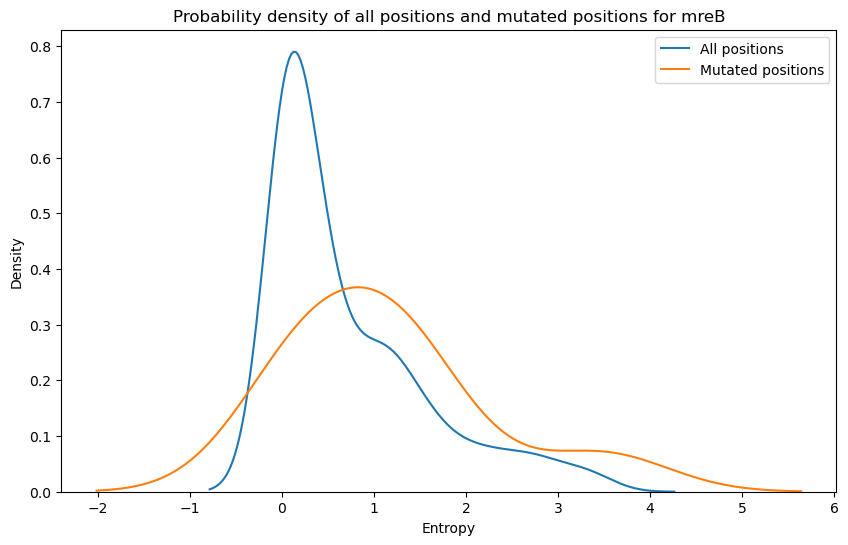

Mann-Whitney U test results:
Statistic: 5300.0
P-value: 0.11309007552377526
The mutated positions are not statistically different from randomly drawn positions (p >= 0.05).

Permutation test results:
Observed correlation: 0.9524409853202791
P-value: 0.001
The chosen mutations are significantly influenced by their masked marginal probability (p < 0.05).

rho
------


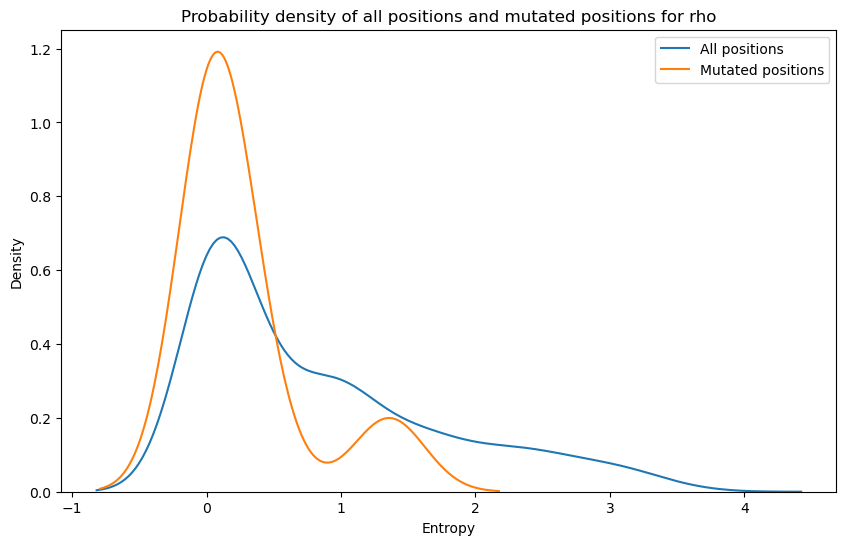

Mann-Whitney U test results:
Statistic: 4708.5
P-value: 0.013262962590407658
The mutated positions are statistically different from randomly drawn positions (p < 0.05).

Permutation test results:
Observed correlation: 0.8337756802536559
P-value: 0.0
The chosen mutations are significantly influenced by their masked marginal probability (p < 0.05).

spoT
------


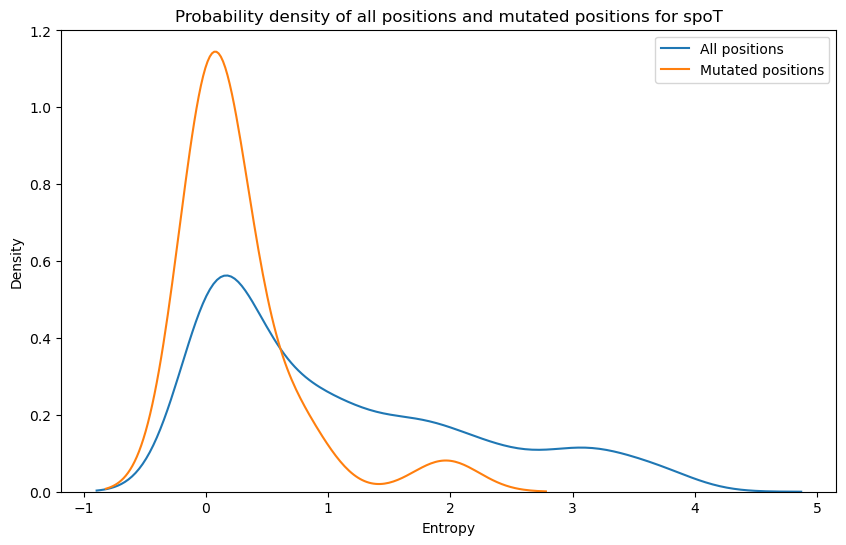

Mann-Whitney U test results:
Statistic: 4767.0
P-value: 0.0006182861312253999
The mutated positions are statistically different from randomly drawn positions (p < 0.05).

Permutation test results:
Observed correlation: 0.8100897920561253
P-value: 0.0
The chosen mutations are significantly influenced by their masked marginal probability (p < 0.05).

rpoA
------


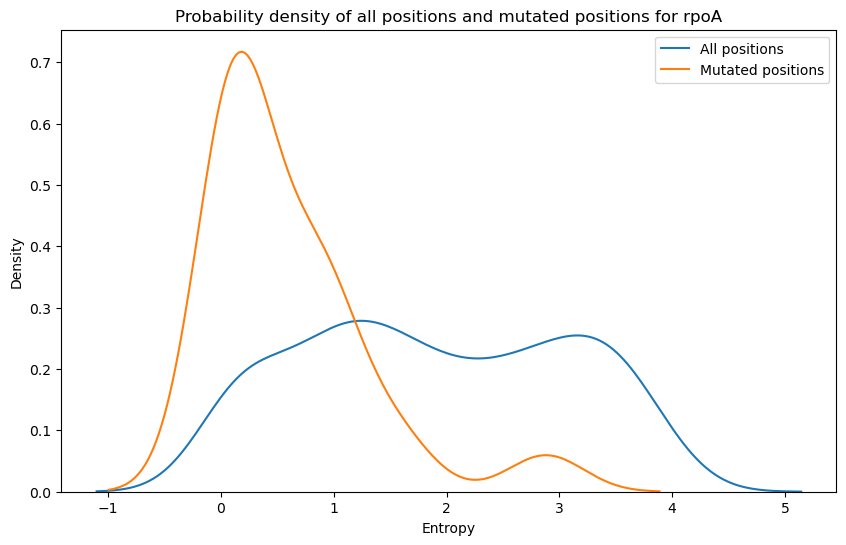

Mann-Whitney U test results:
Statistic: 6717.5
P-value: 1.0020303245398254e-12
The mutated positions are statistically different from randomly drawn positions (p < 0.05).

Permutation test results:
Observed correlation: 0.7623319106989914
P-value: 0.0
The chosen mutations are significantly influenced by their masked marginal probability (p < 0.05).

metJ
------


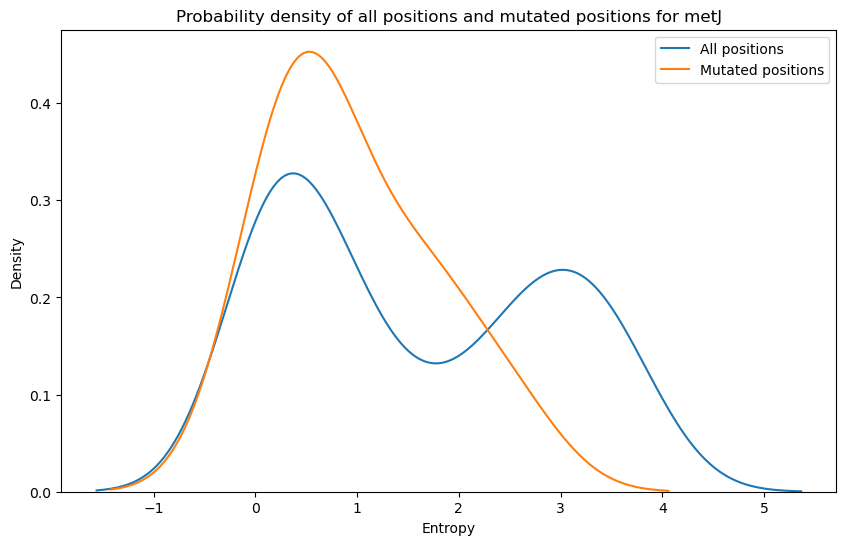

Mann-Whitney U test results:
Statistic: 3492.0
P-value: 0.24700601772489383
The mutated positions are not statistically different from randomly drawn positions (p >= 0.05).

Permutation test results:
Observed correlation: 0.5287034862130648
P-value: 0.136
The chosen mutations are not significantly influenced by their masked marginal probability (p >= 0.05).



In [125]:
for name, seq in zip(names, seqs):
    print(name)
    print('------')
    plot_entropy_density(name, seq, data)
    perform_statistical_test(name, seq, data, num_random_samples=1000)
    print()
    observed_correlation, substituted_mmp_values, other_mmp_values_sum = calculate_mmp_correlation(name, seq)
    permutation_test(name, seq, data, substituted_mmp_values, other_mmp_values_sum, n_permutations=1000)
    print()

# Visualizing protein Structure
---

In [126]:
pdb_files = [f"../results/{name}/{name}.pdb" for name in names]
pdb_files

#for name, pdb in zip(names, pdb_files):
#    print(name)
#    view = show_pdb(pdb)
#    view.show()

mreB


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

rho


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

spoT


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

rpoA


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

metJ


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol